※　統計的機械学習ー生成モデルに基づくパターン認識ー（杉山将,2019）の第10章の内容に基づいて実装した

In [1]:
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# モンテカルロ法：pi の近似計算

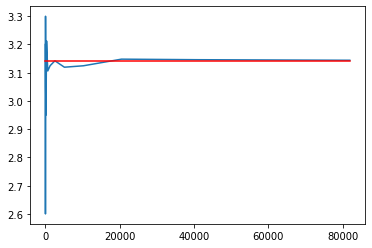

In [2]:
def g(x,y):
    if (x*x+y*y<=1):
        return 1
    else:
        return 0

n = 10
N = []
P = []
while n <= 100000:
    s = np.random.uniform(-1,1,(n,2))
    nn = 0
    for x in s:
        nn+=g(x[0],x[1])
        
    pi = 4*nn/n
    N.append(n)
    P.append(pi)
    n = n*2

P_r = [np.pi]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
plt.show()

# 重点サンプリング法：ラプラス分布の分散の近似計算

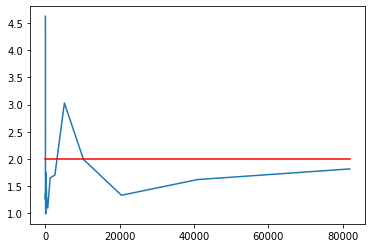

In [3]:
def g(x):
    return x*x
def p_pdf(x):
    return 0.5*np.exp(-abs(x))
def imp_pdf(x):
    return norm.pdf(x)

n = 10
N = []
P = []
while n <= 100000:
    s = np.random.normal(0,1,n)
    nn = 0
    for x in s:
        nn+=g(x)*p_pdf(x)/imp_pdf(x)
        
    p = nn/n
    N.append(n)
    P.append(p)
    n = n*2

P_r = [2]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
plt.show()

# 逆関数サンプリング法：ラプラス分布

In [4]:
def sgn(x):
    if x>0:
        return 1
    elif x==0:
        return 0
    else:
        return -1
    
def p_laplace(x):
    return 0.5*np.exp(-abs(x))

#def P_laplace_cum(x):
    #return 0.5*((1+sgn(x))(1-np.exp(-abs(x))))

def P_laplace_inv(u):
    k = 1-2*abs(u-0.5)
    return -1*sgn(u-0.5)*np.log(k)

def generate_theta(X):
    res = []
    for u in X:
        res.append(P_laplace_inv(u))
    return res

### ラプラス分布に従う確率変数の生成（逆関数サンプリング法）

n_sample =  50


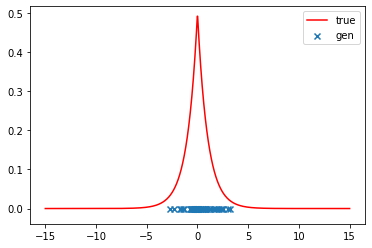

In [5]:
n_sample = 50
s = np.random.uniform(0,1,n_sample)
theta = generate_theta(s)
   
print("n_sample = ",n_sample)
gen_xx =random.sample(theta,n_sample)
plt.scatter(gen_xx,[0]*n_sample,marker='x')
xx=np.linspace(-15,15,1000)
plt.plot(xx,[p_laplace(i) for i in xx],c='red')
plt.legend(['true','gen'])
plt.show()

### 生成された標本を用いたモンテカルロ積分の計算：ラプラス分布の分散

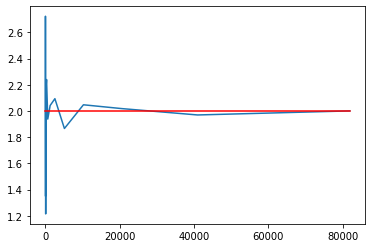

In [6]:
N = []
P = []
n= 10
while n <= 100000:
    s = np.random.uniform(0,1,n)
    theta = generate_theta(s)
    p = 0
    for x in theta:
        p += x*x
    N.append(n)
    P.append(p/n)
    n = n*2
    
P_r = [2]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
